<a href="https://colab.research.google.com/github/ashishmahan/Enhancing-Hierarchical-Text-Classification/blob/main/Enhancing%20Hierarchical%20Text%20Classification_From%20Traditional%20Machine%20Learning%20to%20Deep%20Learning%20with%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initially, I attempted to solve the problem using traditional machine learning techniques. The approach involved:

**Text Vectorization:**

Using **'TfidfVectorizer'** from **'sklearn.feature_extraction.text'** to convert the text data into numerical form. The **max_features** parameter was set to 10,000 to limit the dimensionality.

**Classification Model:**

 A **LogisticRegression** model was trained for each category level using the **MultiOutputClassifier** to handle the multi-label nature of the problem.

**Pipeline Setup:**

 The text vectorization and logistic regression were combined into a single pipeline for ease of processing.

**Results:**

Cat1 Accuracy: 0.7545

Cat2 Accuracy: 0.4895

Cat3 Accuracy: 0.32

The traditional approach was straightforward and computationally efficient. However, it struggled with the deeper levels of the hierarchy, particularly Cat2 and Cat3, where the accuracy dropped significantly.


To address the limitations of the initial approach, I switched to a deep learning model, which is better suited for capturing the complex relationships in hierarchical classification tasks.

**Deep Learning with LSTM based Approach that I used to solve this task:**

**1. Preprocessing:**

Tokenization and text vectorization.

Encoded target labels using **Label Encoder** method for the three hierarchical levels. Also padded the sequences to 200 tokens to ensure uniform input length.

An embedding layer was used to convert the input text sequences into dense vectors.


**2. Model Design:**

A Bidirectional LSTM model with 256 LSTM units (e.g., using a shared base model with multiple output layers corresponding to each category level). I applied class weights to give more importance to less frequent categories. I also used Dropout Regularization and Early Stopping during training to prevent overfitting.

Separate dense layers were used to output predictions for each category level (Cat1, Cat2, and Cat3), respecting the hierarchy.

**3. Training and Evaluation:**

Categorical cross-entropy loss was used for each output.

Trained the model on the dataset, ensuring hierarchical consistency.

Evaluated accuracy at each level of the category hierarchy.

Also I predicted the model on a sample text "This product is fantastic and works great for my dog!"

In [ ]:
import zipfile
import os

zip_file_path = '/content/data.csv.zip'
extraction_dir = '/content/extracted_data'

os.makedirs(extraction_dir, exist_ok=True)

# Extracted the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# List the extracted files
extracted_files = os.listdir(extraction_dir)
extracted_files


['data.csv', '__MACOSX']

In [ ]:
import pandas as pd

csv_file_path = os.path.join(extraction_dir, 'data.csv')
data = pd.read_csv(csv_file_path)

data.head(), data.columns


(    productId                                              Title  \
 0  B0002AQK70     PetSafe Staywell Pet Door with Clear Hard Flap   
 1  B0002DK8OI                      Kaytee Timothy Cubes, 1-Pound   
 2  B0006VJ6TO                                    Body Back Buddy   
 3  B000EZSFXA         SnackMasters California Style Turkey Jerky   
 4  B000KV61FC  Premier Busy Buddy Tug-a-Jug Treat Dispensing ...   
 
            userId        Time  \
 0  A2L6QTQQI13LZG  1344211200   
 1   A2HJUOZ9R9K4F  1344211200   
 2  A14PK96LL78NN3  1344211200   
 3  A2UW73HU9UMOTY  1344211200   
 4  A1Q99RNV0TKW8R  1344211200   
 
                                                 Text                  Cat1  \
 0  We've only had it installed about 2 weeks. So ...          pet supplies   
 1  My bunny had a hard time eating this because t...          pet supplies   
 2  would never in a million years have guessed th...  health personal care   
 3  Being the jerky fanatic I am, snackmasters han...  grocery

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   productId  10000 non-null  object
 1   Title      9995 non-null   object
 2   userId     10000 non-null  object
 3   Time       10000 non-null  int64 
 4   Text       10000 non-null  object
 5   Cat1       10000 non-null  object
 6   Cat2       10000 non-null  object
 7   Cat3       10000 non-null  object
dtypes: int64(1), object(7)
memory usage: 625.1+ KB


In [ ]:
# removing special characters from data using regular expressions

import re
p = re.compile(r'[^\w\s]+')

data['Text'] = [p.sub('', x) for x in data['Text']]

In [ ]:
# make all characters lower()

data.apply(lambda x: x.astype(str).str.lower())

In [ ]:
data.loc[100, 'Cat1'], data.loc[100, 'Cat2'], data.loc[100, 'Cat3']

('pet supplies', 'dogs', 'houses')

In [ ]:
data.loc[100, 'Text']

'I bought this for my maltese needless to say Its perfectIts big enough to fit food water bed and tons of toys for my dogI can even fit wee wee pad but he wont go on wee wee padand hold it until I come home from work I still leave wee wee pad just in caseIts so cute he keeps going in and out to get his toys drink water and eat his food when I leave the door openIf you dont believe in putting your dog in the regular kennel cratethis is perfect I definitely do not want to put my dog in that small crate locked upEasy to put together I am girl and was able to do it by myselfthere are little rubber pieces that comes with in order to prevent slidingdurable and ITs pretty'

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Extracted relevant columns
texts = data['Text']
cat1_labels = data['Cat1']
cat2_labels = data['Cat2']
cat3_labels = data['Cat3']

label_encoder_cat1 = LabelEncoder()
label_encoder_cat2 = LabelEncoder()
label_encoder_cat3 = LabelEncoder()

cat1_encoded = label_encoder_cat1.fit_transform(cat1_labels)
cat2_encoded = label_encoder_cat2.fit_transform(cat2_labels)
cat3_encoded = label_encoder_cat3.fit_transform(cat3_labels)

# Tokenized the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to ensure uniform input length
max_sequence_length = 200  # Limited to 200 tokens for efficiency
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

X_train, X_test, y_train_cat1, y_test_cat1, y_train_cat2, y_test_cat2, y_train_cat3, y_test_cat3 = train_test_split(
    padded_sequences, cat1_encoded, cat2_encoded, cat3_encoded, test_size=0.2, random_state=42)

# Get the size of the vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Get the number of unique classes for each category level
num_classes_cat1 = len(label_encoder_cat1.classes_)
num_classes_cat2 = len(label_encoder_cat2.classes_)
num_classes_cat3 = len(label_encoder_cat3.classes_)

(vocab_size, num_classes_cat1, num_classes_cat2, num_classes_cat3)


(26164, 6, 64, 377)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

input_layer = Input(shape=(max_sequence_length,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length)(input_layer)

# Shared LSTM layers
lstm_layer = Bidirectional(LSTM(256, return_sequences=False))(embedding_layer)

dropout_layer = Dropout(0.5)(lstm_layer)

# Calculate class weights for each category
class_weight_cat1 = compute_class_weight('balanced', classes=np.unique(y_train_cat1), y=y_train_cat1)
class_weight_cat2 = compute_class_weight('balanced', classes=np.unique(y_train_cat2), y=y_train_cat2)
class_weight_cat3 = compute_class_weight('balanced', classes=np.unique(y_train_cat3), y=y_train_cat3)

# Created a dictionary for class weights
class_weights = {
    'output_cat1': dict(enumerate(class_weight_cat1)),
    'output_cat2': dict(enumerate(class_weight_cat2)),
    'output_cat3': dict(enumerate(class_weight_cat3))
}

# Output layers for each category level
output_cat1 = Dense(num_classes_cat1, activation='softmax', name='output_cat1')(dropout_layer)
output_cat2 = Dense(num_classes_cat2, activation='softmax', name='output_cat2')(dropout_layer)
output_cat3 = Dense(num_classes_cat3, activation='softmax', name='output_cat3')(dropout_layer)

model = Model(inputs=input_layer, outputs=[output_cat1, output_cat2, output_cat3])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics={'output_cat1': 'accuracy',
                       'output_cat2': 'accuracy',
                       'output_cat3': 'accuracy'})


model.summary()


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train,
                    [y_train_cat1, y_train_cat2, y_train_cat3],
                    validation_data=(X_test, [y_test_cat1, y_test_cat2, y_test_cat3]),
                    epochs=30,
                    batch_size=128,
                    callbacks=[early_stopping])

# Train the model
#history = model.fit(X_train, [y_train_cat1, y_train_cat2, y_train_cat3],
                    #validation_data=(X_test, [y_test_cat1, y_test_cat2, y_test_cat3]),
                    #epochs=10, batch_size=128)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 200, 128)       │      2,723,840 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 512)            │        788,480 │ embedding_7[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 512)            │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_cat1 (Dense)       │ (None, 6)              │          3,078 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_cat2 (Dense)       │ (None, 64)             │         32,832 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_cat3 (Dense)       │ (None, 377)            │        193,401 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,741,631 (14.27 MB)

 Trainable params: 3,741,631 (14.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - loss: 10.9209 - output_cat1_accuracy: 0.2543 - output_cat2_accuracy: 0.0743 - output_cat3_accuracy: 0.0415 - val_loss: 10.0310 - val_output_cat1_accuracy: 0.3125 - val_output_cat2_accuracy: 0.0885 - val_output_cat3_accuracy: 0.0615
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - loss: 9.9296 - output_cat1_accuracy: 0.3339 - output_cat2_accuracy: 0.1025 - output_cat3_accuracy: 0.0741 - val_loss: 9.1894 - val_output_cat1_accuracy: 0.4200 - val_output_cat2_accuracy: 0.1600 - val_output_cat3_accuracy: 0.0860
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - loss: 8.8669 - output_cat1_accuracy: 0.5018 - output_cat2_accuracy: 0.1615 - output_cat3_accuracy: 0.0963 - val_loss: 8.5768 - val_output_cat1_accuracy: 0.5470 - val_output_cat2_accuracy: 0.1935 - val_output_cat3_accuracy: 0.0970
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - loss: 8.1338 - output_cat1_accuracy: 0.6319 - output_cat2_accuracy: 0.2057 - output_cat3_accurac

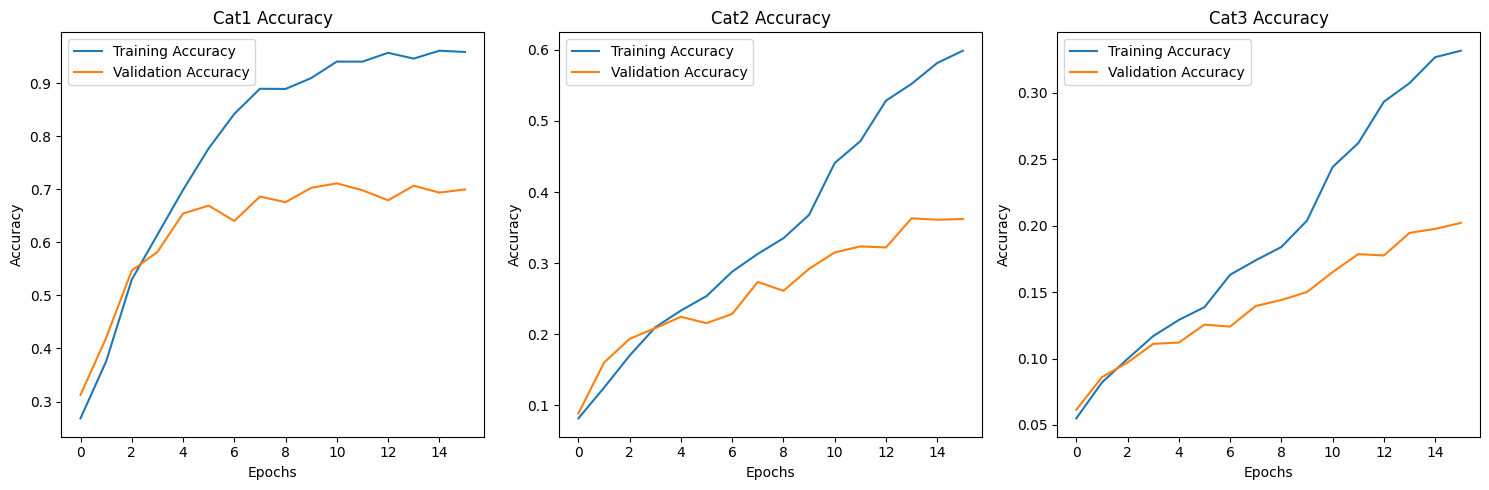

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot for Cat1
plt.subplot(1, 3, 1)
plt.plot(history.history['output_cat1_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_output_cat1_accuracy'], label='Validation Accuracy')
plt.title('Cat1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for Cat2
plt.subplot(1, 3, 2)
plt.plot(history.history['output_cat2_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_output_cat2_accuracy'], label='Validation Accuracy')
plt.title('Cat2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for Cat3
plt.subplot(1, 3, 3)
plt.plot(history.history['output_cat3_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_output_cat3_accuracy'], label='Validation Accuracy')
plt.title('Cat3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Sample text for prediction
sample_text = ["This product is fantastic and works great for my dog!"]

# Preprocessed the sample text
sample_sequence = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_sequence, maxlen=max_sequence_length)

predictions = model.predict(sample_padded)

# Decoded the predictions to their corresponding category labels
predicted_cat1 = label_encoder_cat1.inverse_transform(predictions[0].argmax(axis=1))
predicted_cat2 = label_encoder_cat2.inverse_transform(predictions[1].argmax(axis=1))
predicted_cat3 = label_encoder_cat3.inverse_transform(predictions[2].argmax(axis=1))

print(f"Predicted Cat1: {predicted_cat1[0]}")
print(f"Predicted Cat2: {predicted_cat2[0]}")
print(f"Predicted Cat3: {predicted_cat3[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Cat1: pet supplies
Predicted Cat2: dogs
Predicted Cat3: toys
